In [25]:
import pandas as pd

In [26]:
# Set display options to show full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)

In [27]:
#Load data from data/raw/train
# First column is ind
df = pd.read_csv('../data/raw/training_smiles.csv', index_col=0)


In [28]:
df.head()

,SMILES,ACTIVE
INDEX,,
1,CCOc1cc(CNc2cccc3ccccc23)cc(Br)c1OCC(=O)NC(C)(C)C,0.0
2,COc1cc(-c2ccc(Nc3ccccc3C(=O)O)c(OC)c2)ccc1Nc1ccccc1C(=O)O,0.0
3,O=c1cc(O)n(-c2ccc(Cl)cc2)c(=S)[nH]1,0.0
4,COc1ccc(NC(=O)C/C(C)=N/NC(=O)CCc2ccccc2)c(OC)c1,0.0
5,CC(=O)/C=C(\C)NCCNc1c(F)c(F)c(CO)c(F)c1F,0.0


In [29]:
df.shape

(208938, 2)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 208938 entries, 1 to 208938
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   SMILES  208938 non-null  object 
 1   ACTIVE  208938 non-null  float64
dtypes: float64(1), object(1)
memory usage: 4.8+ MB


In [31]:
missing_values = df.isnull().sum()
print(missing_values)

SMILES    0
ACTIVE    0
dtype: int64


In [32]:
duplicate_count = df.duplicated().sum()
print(f'Duplicate Rows: {duplicate_count}')

Duplicate Rows: 226


In [33]:
df.describe()

,ACTIVE
count,208938.000000
mean,0.037968
std,0.191120
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [34]:
df.describe(include=['object'])

,SMILES
count,208938
unique,208708
top,COc1c2c(cc3c1OCO3)CC[N+](C)=C2
freq,3


In [36]:
df['ACTIVE'].value_counts()

ACTIVE
0.0    201005
1.0      7933
Name: count, dtype: int64

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

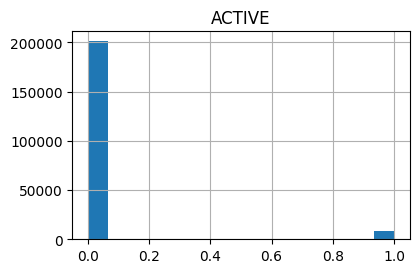

In [40]:
df[num_cols].hist(bins=15, figsize=(15, 10), layout=(4, 4))
plt.tight_layout()
plt.show()

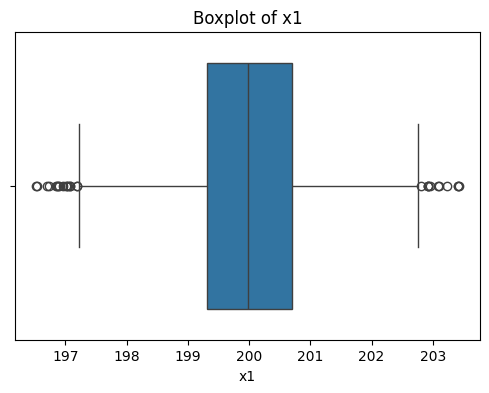

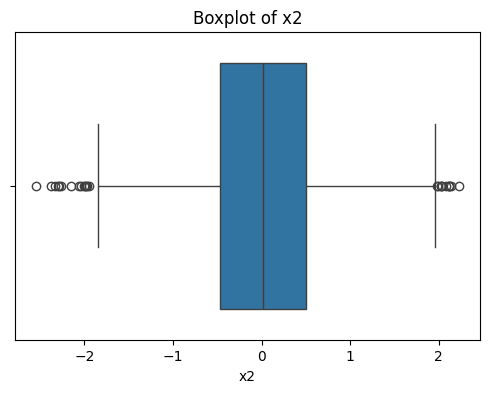

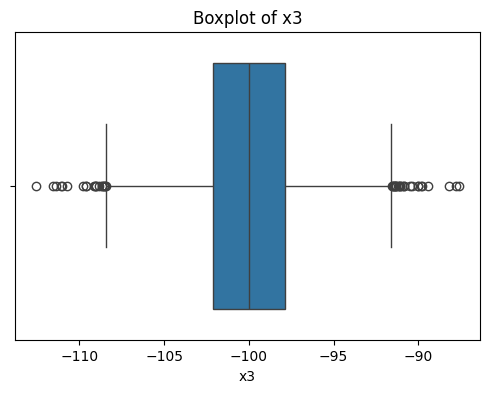

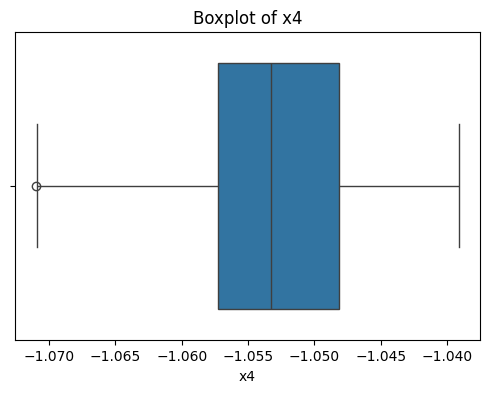

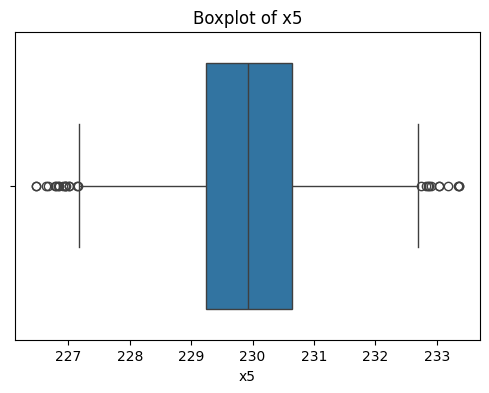

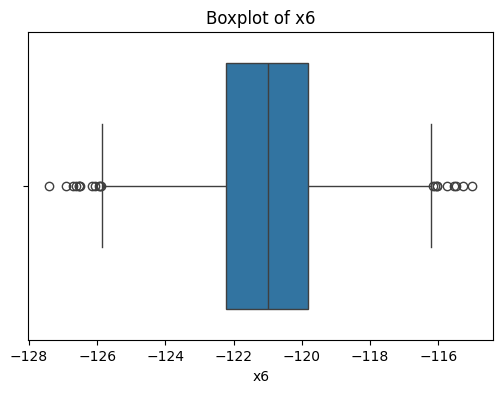

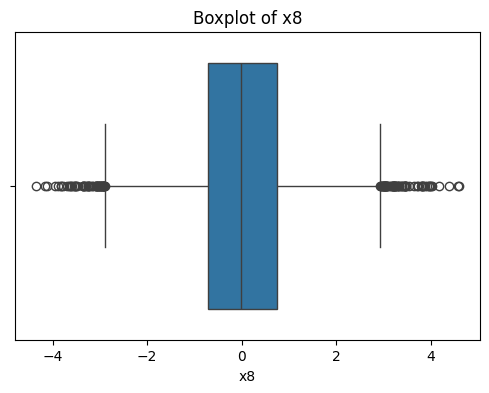

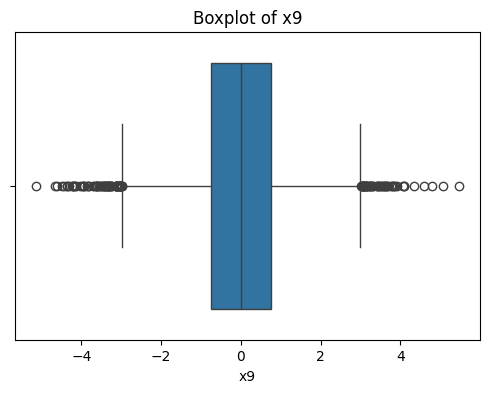

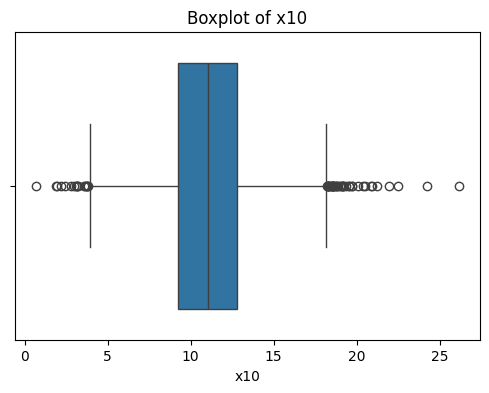

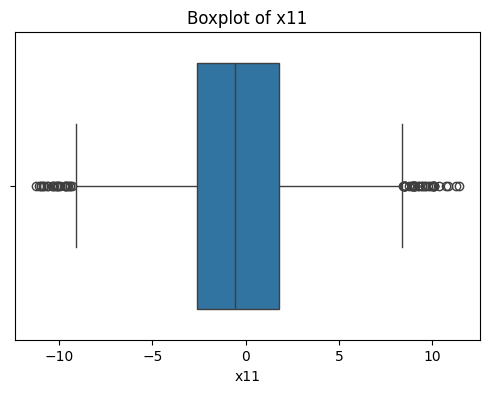

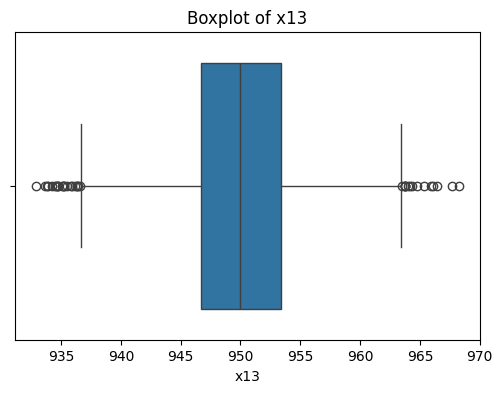

In [54]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

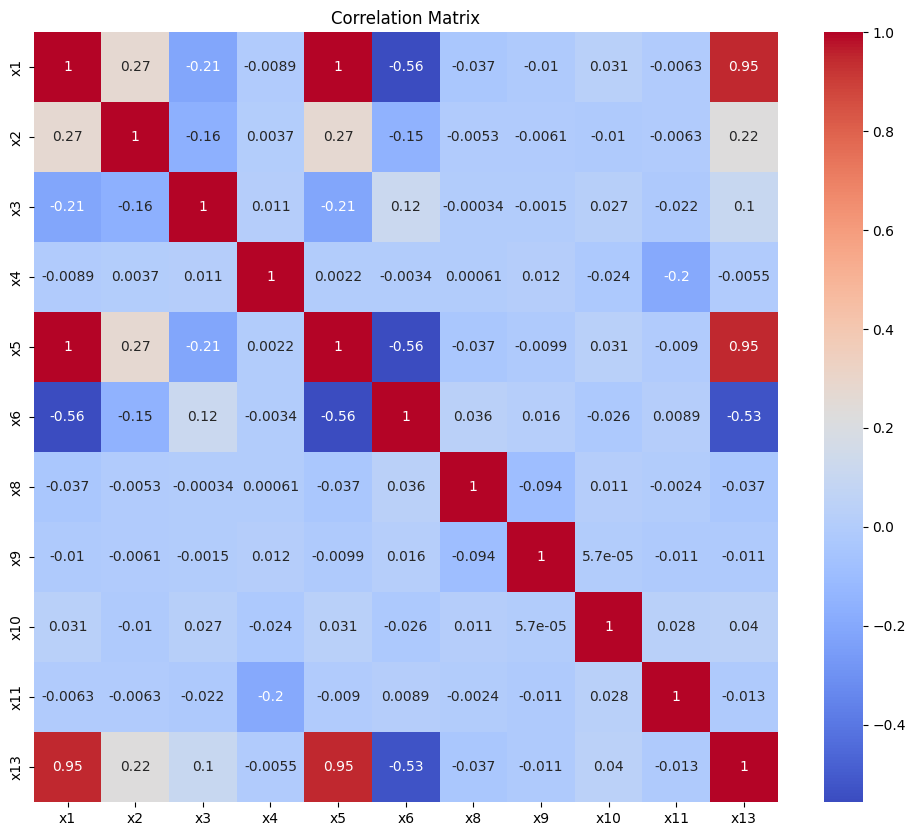

In [55]:
corr_matrix = df[num_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

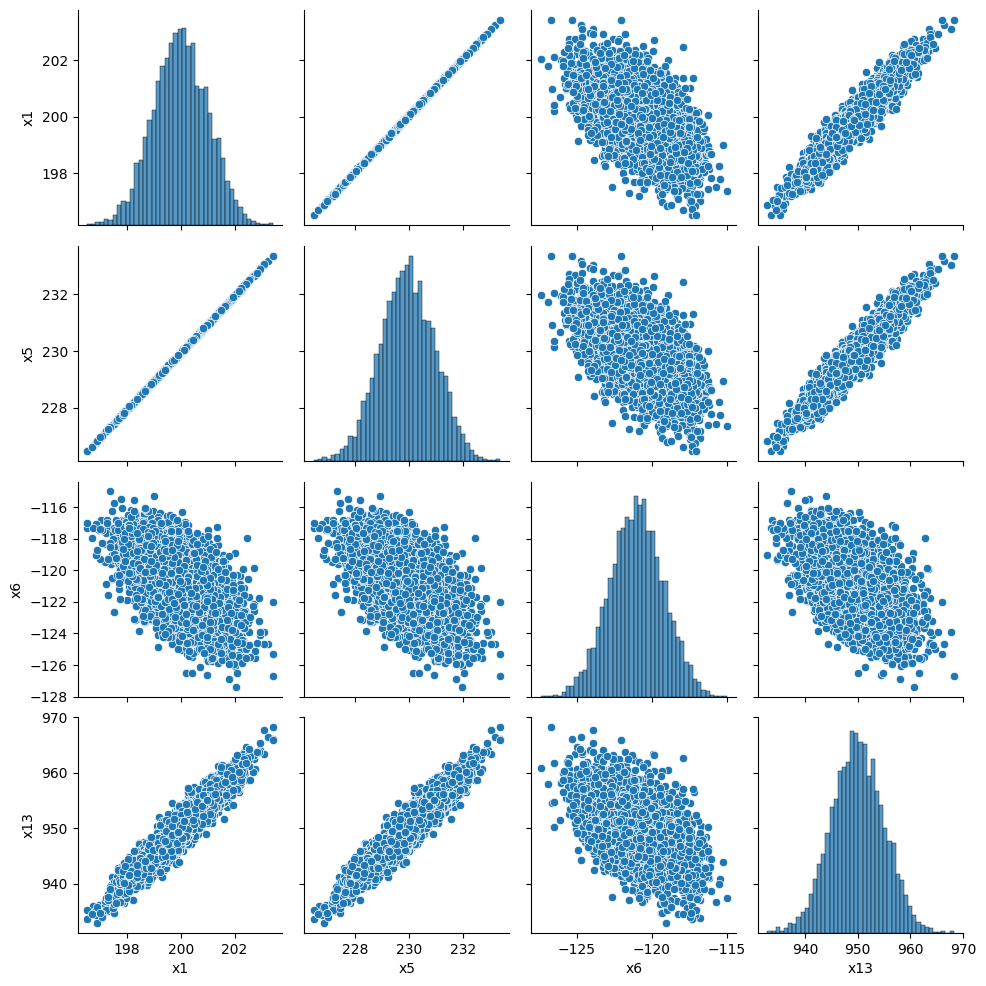

In [56]:
sns.pairplot(df, vars=['x1', 'x5', 'x6', 'x13'])
plt.show()

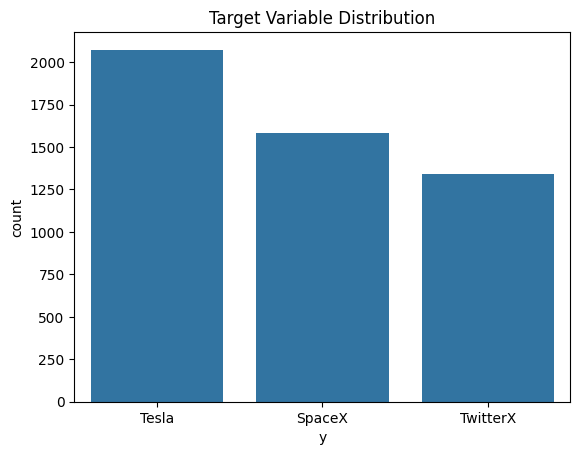

In [57]:
sns.countplot(x='y', data=df)
plt.title('Target Variable Distribution')
plt.show()

In [58]:
from scipy.stats import f_oneway
import numpy as np

In [59]:
# Function to calculate correlation ratio (similar to eta-squared)
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = numerator/denominator
    return eta

In [60]:
# Calculate correlation ratio for each numerical feature
num_features = df.select_dtypes(include=['int64', 'float64']).columns
correlations = {}
for col in num_features:
    correlations[col] = correlation_ratio(df['y'], df[col])


In [61]:
# Sort correlations
sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)


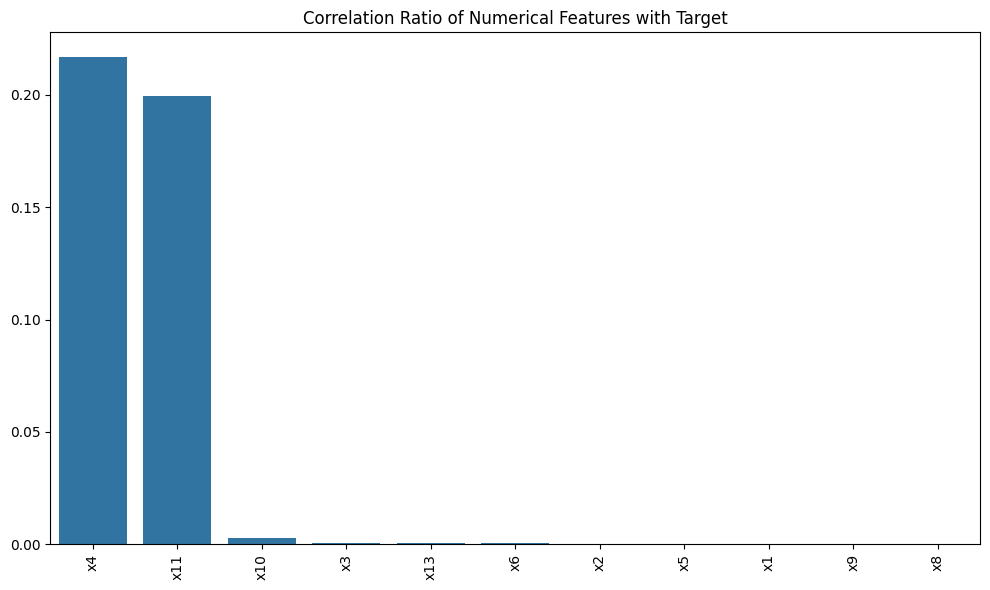

In [62]:
# Plot correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=[x[0] for x in sorted_correlations], y=[x[1] for x in sorted_correlations])
plt.xticks(rotation=90)
plt.title('Correlation Ratio of Numerical Features with Target')
plt.tight_layout()
plt.show()

In [63]:
from scipy.stats import chi2_contingency


In [64]:
# Function to calculate Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


In [65]:
# Calculate Cramer's V for each categorical feature
cat_features = df.select_dtypes(include=['object']).columns
cat_correlations = {}
for col in cat_features:
    if col != 'y':  # Exclude the target variable itself
        cat_correlations[col] = cramers_v(df[col], df['y'])


In [66]:
# Sort correlations
sorted_cat_correlations = sorted(cat_correlations.items(), key=lambda x: x[1], reverse=True)


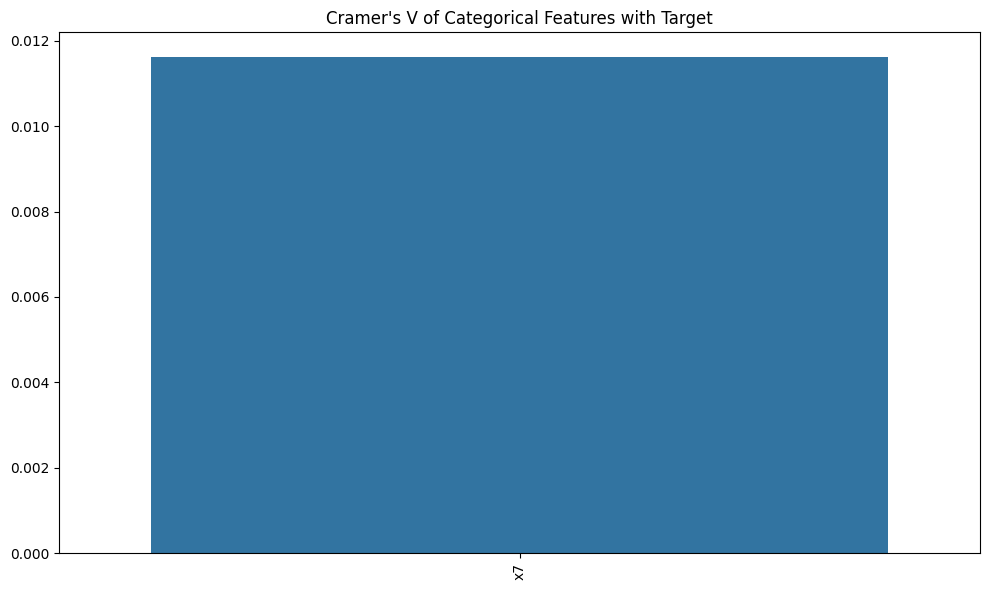

In [67]:
# Plot correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=[x[0] for x in sorted_cat_correlations], y=[x[1] for x in sorted_cat_correlations])
plt.xticks(rotation=90)
plt.title("Cramer's V of Categorical Features with Target")
plt.tight_layout()
plt.show()

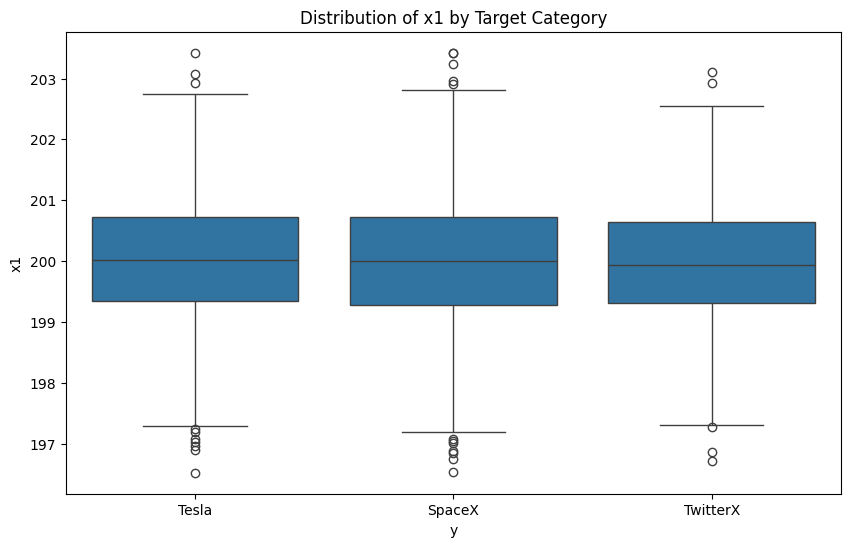

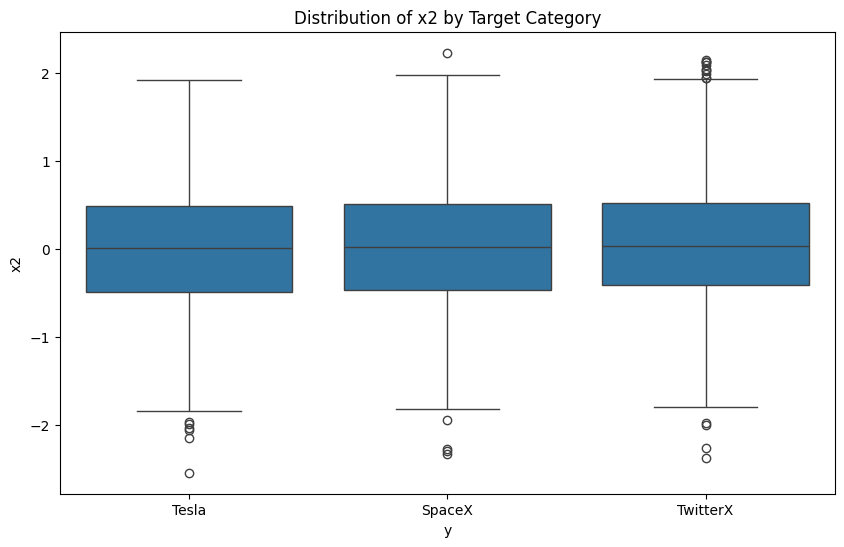

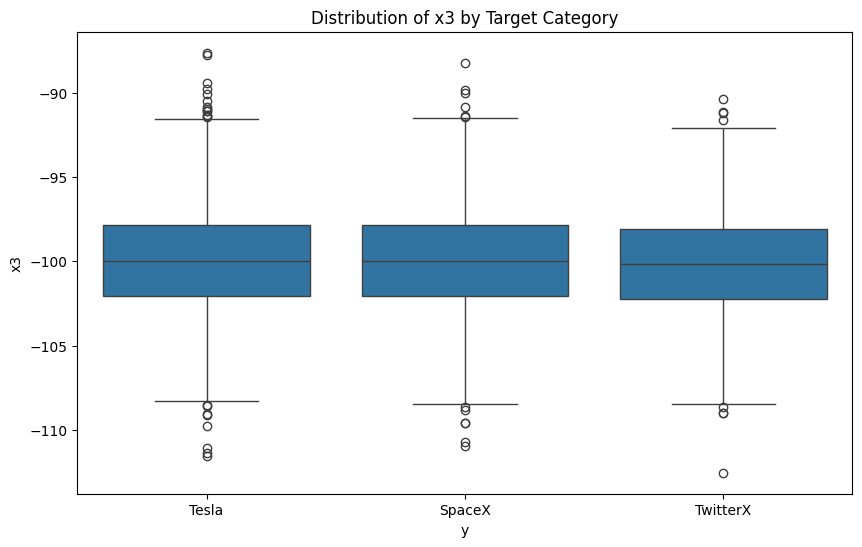

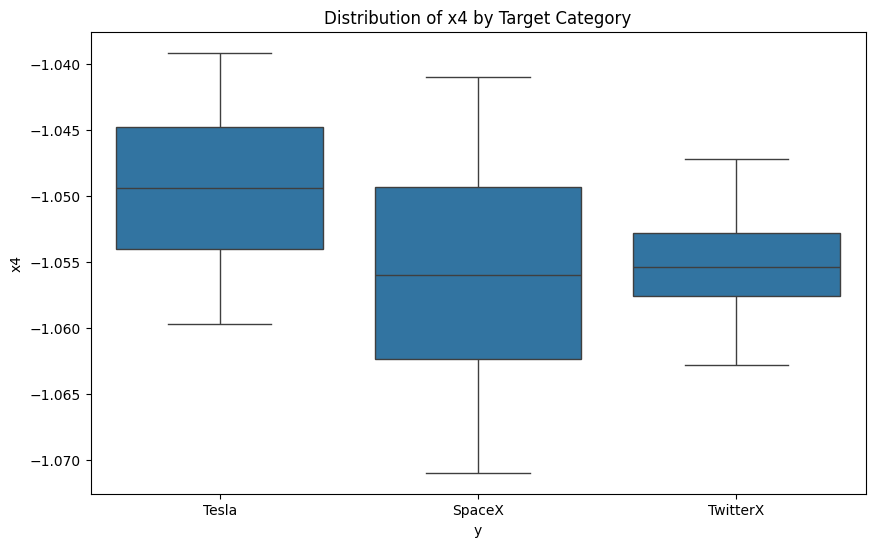

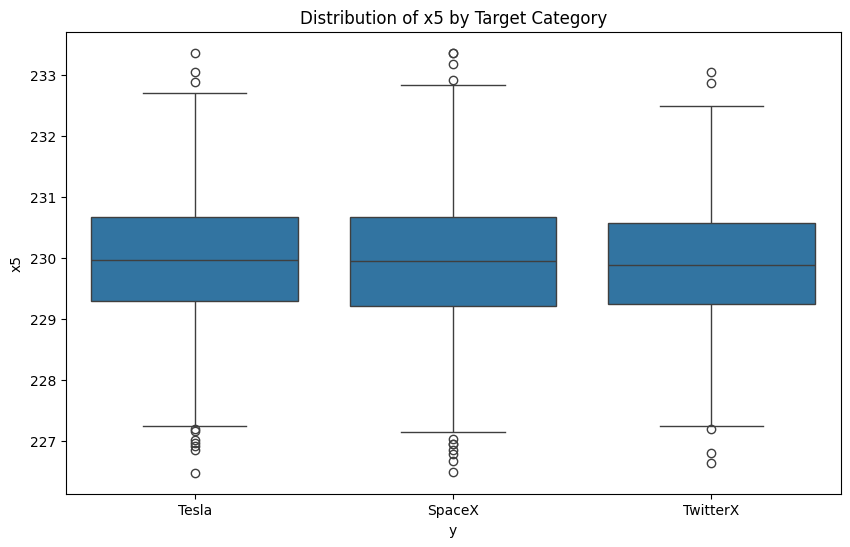

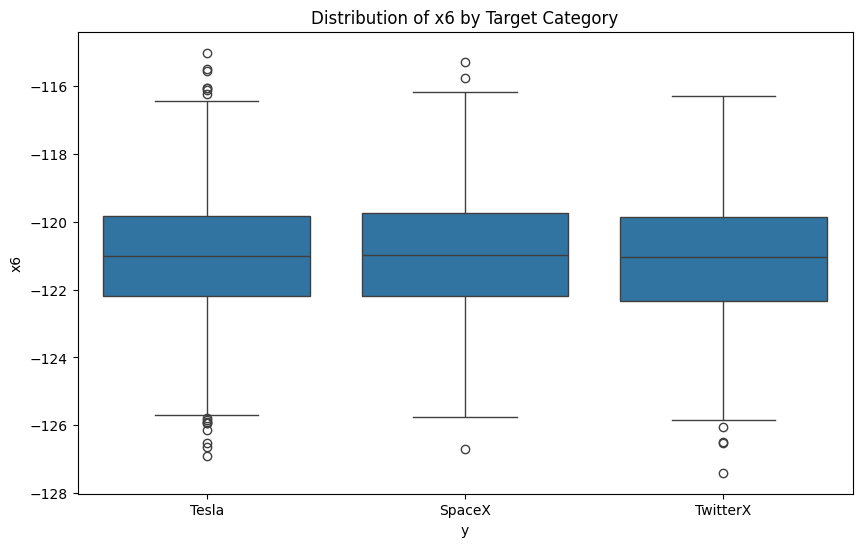

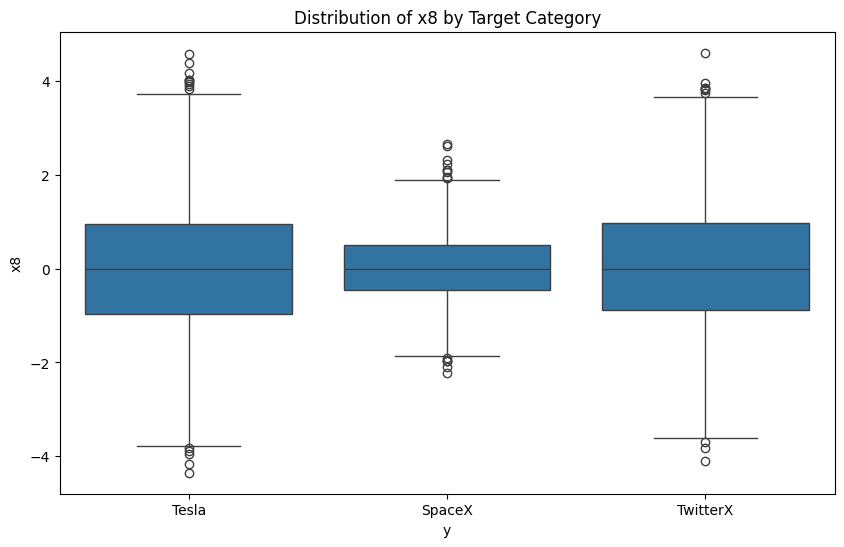

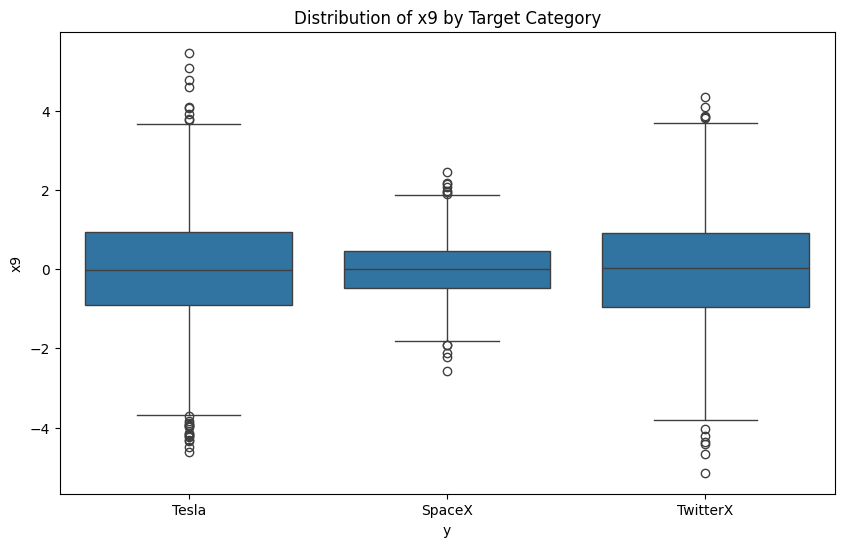

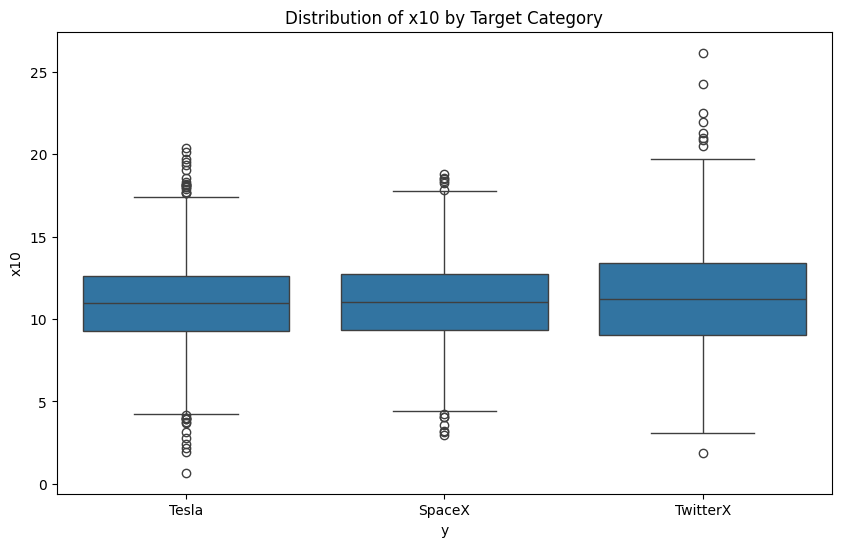

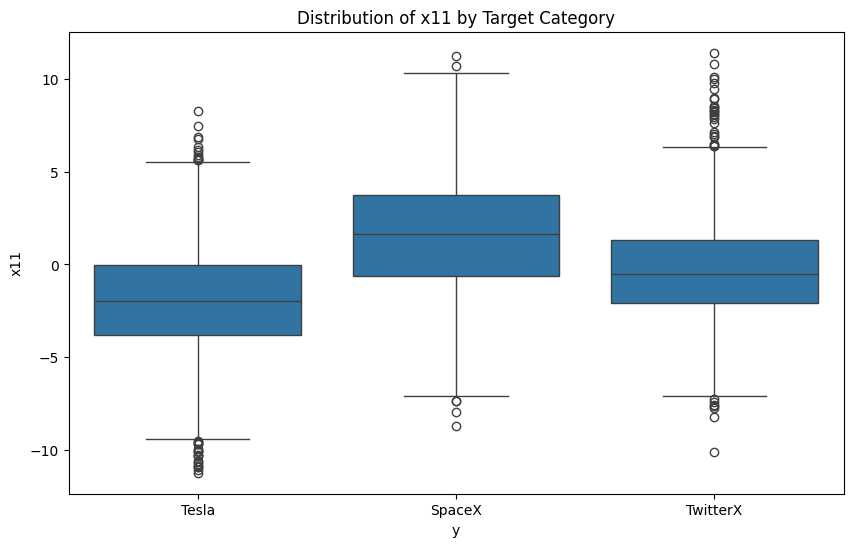

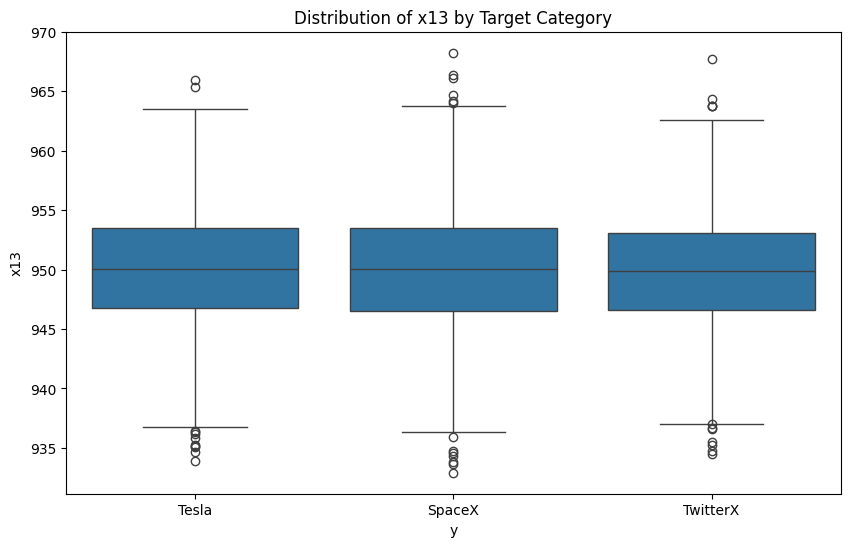

In [68]:
# For numerical features
for col in num_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='y', y=col, data=df)
    plt.title(f'Distribution of {col} by Target Category')
    plt.show()

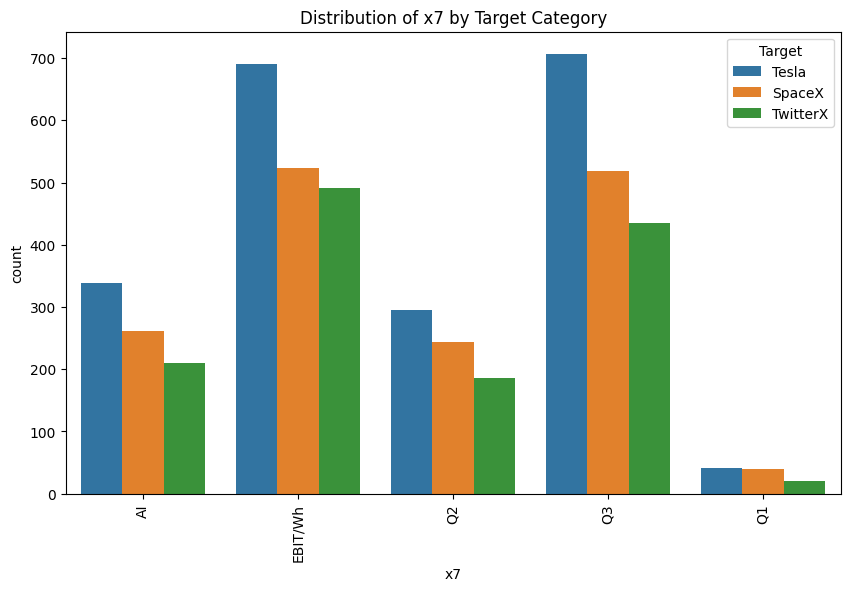

In [69]:
# For categorical features
for col in cat_features:
    if col != 'y':
        plt.figure(figsize=(10, 6))
        sns.countplot(x=col, hue='y', data=df)
        plt.title(f'Distribution of {col} by Target Category')
        plt.xticks(rotation=90)
        plt.legend(title='Target')
        plt.show()

In [70]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

In [71]:
le = LabelEncoder()
y_encoded = le.fit_transform(df['y'])

In [72]:
chi_features = df.select_dtypes(include=['object']).columns
X_categorical = df[chi_features]

In [73]:
X_encoded = pd.get_dummies(X_categorical, drop_first=True)


In [74]:
chi_scores = chi2(X_encoded, y_encoded)
chi_scores_df = pd.DataFrame({'Feature': X_encoded.columns, 'Chi2 Score': chi_scores[0], 'p-value': chi_scores[1]})
chi_scores_df.sort_values(by='Chi2 Score', ascending=False, inplace=True)
print(chi_scores_df.head(10))

      Feature   Chi2 Score   p-value
1  y_TwitterX  3657.000000  0.000000
0     y_Tesla  2927.000000  0.000000
2  x7_EBIT/Wh     3.428587  0.180091
3       x7_Q1     3.406366  0.182103
4       x7_Q2     1.268434  0.530351
5       x7_Q3     0.895187  0.639164
